Top Droplet Diameter: 208.0 Bottom Droplet Diameter: 213.0
Conversion coefficient (pixel to mm): 0.028661417322834646
Bridge width: 47.375
Top Droplet Diameter: 206.75 Bottom Droplet Diameter: 212.875
Conversion coefficient (pixel to mm): 0.028661417322834646
Bridge width: 138.0


IndexError: index 457 is out of bounds for axis 0 with size 440

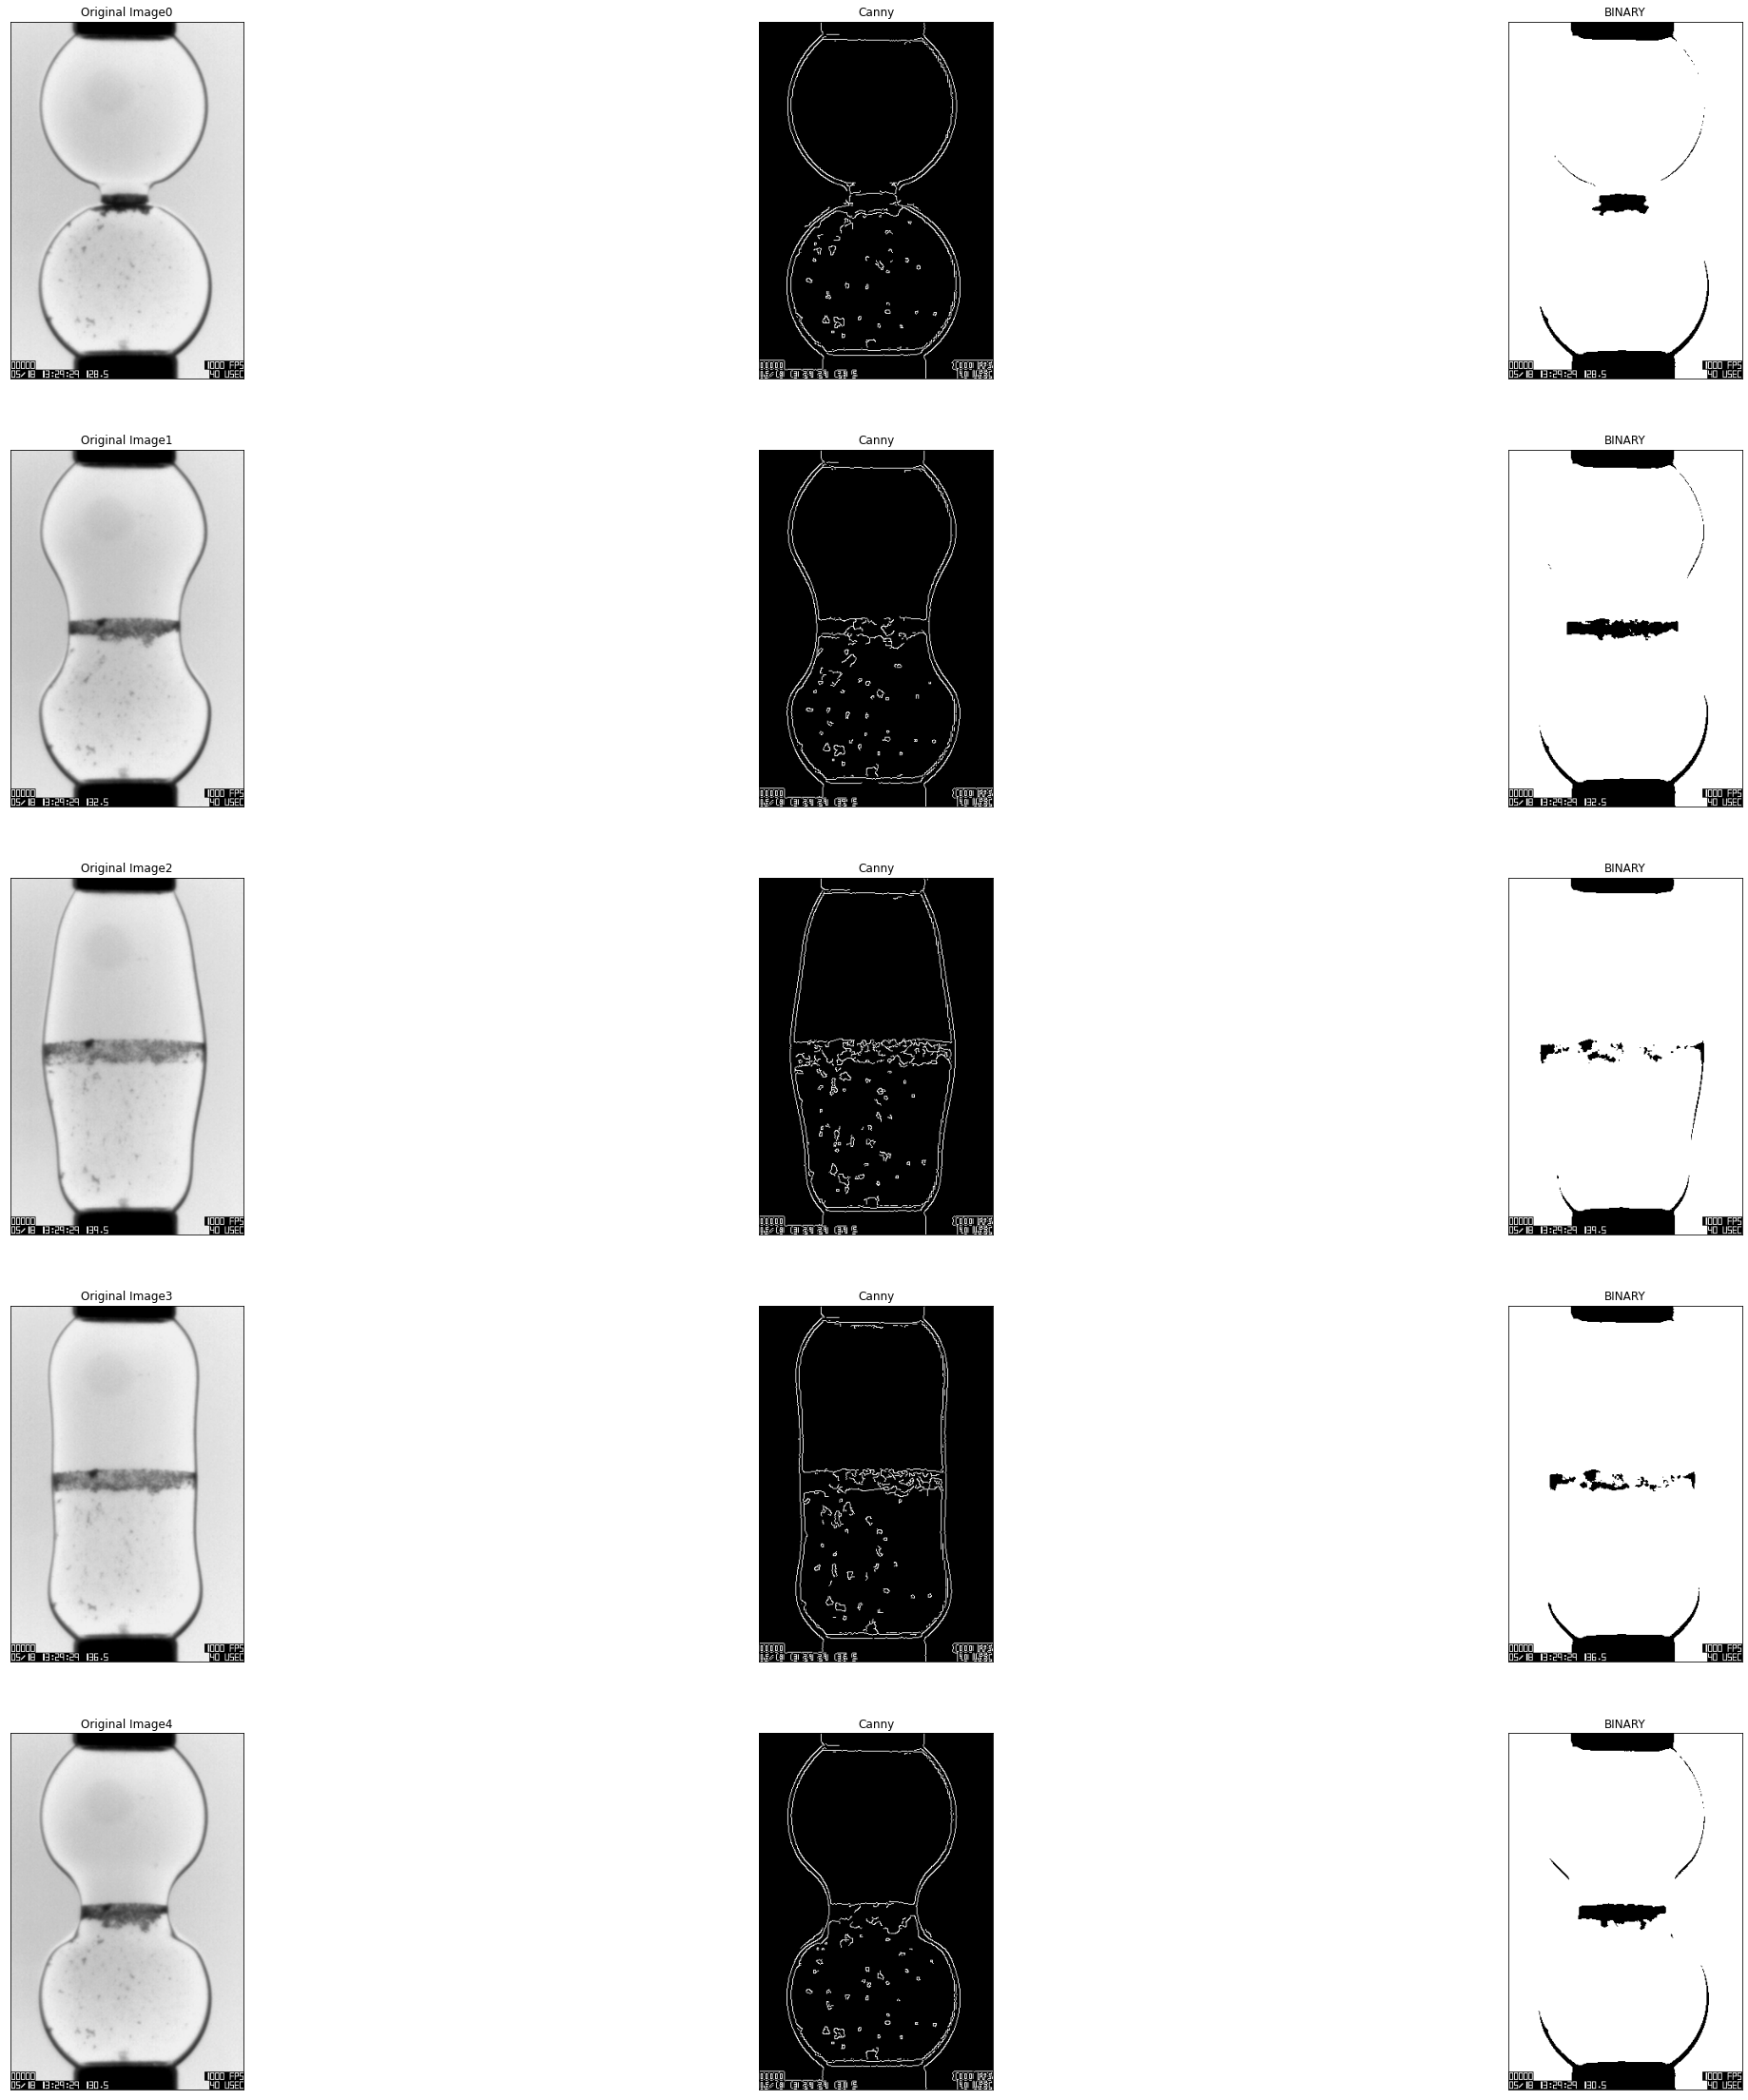

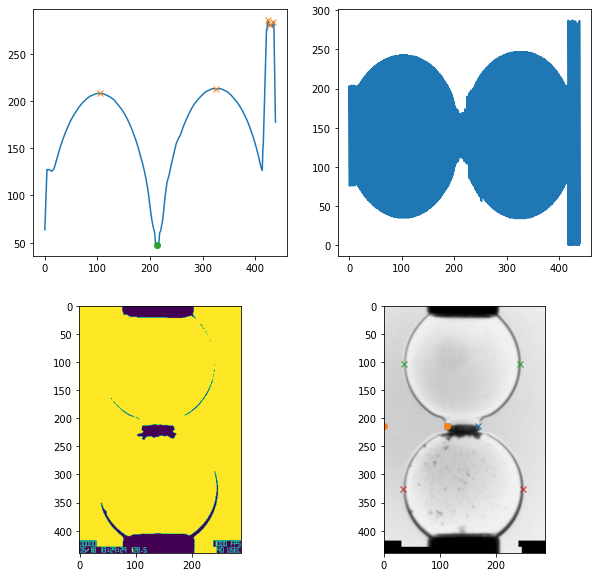

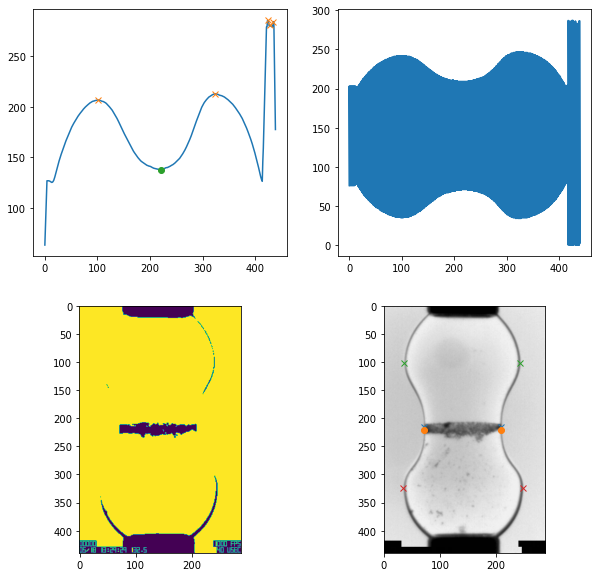

In [2]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import csv

#imageFolderName = 'Alg1.0%w WP 10cSt'
#imageFolderName = 'Alg2.0%w WP 10cSt'
#imageFolderName = 'Alg3.0%w WP 10cSt'
#imageFolderName = 'Alg4.0%w WP 10cSt 3'
#imageFolderName = 'Alg5.0%w WP 10cSt'

imageFolderName = 'imagesofdroplets'
spring_needle_diameter = 1.82 #mm

"""
Load images in folder name 'imageFolderName'
"""
images = []
for file in glob.glob(imageFolderName + "/*.bmp"):
    #print(file)
    image = cv2.imread(file)
    images.append(image)
    
img_number = len(images)
img_h, img_w,img_ch = images[0].shape
img_h_h = int(img_h/2)
img_w_h = int(img_w/2)
#print(f'width: {img_w} height: {img_h} channels: {img_ch}')

"""
Preprocess images: blur -> edge detect & color thresholding
"""

imgs_edges = []
imgs_thresh = []
z = 0
fig = plt.figure(figsize=(40, 40))
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))


"""
Create CVS file and add headers
"""
with open(imageFolderName + '.csv',mode = 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow( ['Image No','Bridge Diameter','Droplet Diamter (top)','Droplet Diameter (bottom)','pix2mm coeffient'])
        
for i in images:
    gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    img_toneMap = clahe.apply(gray)
    
    #blur = cv2.GaussianBlur(i,(5,5),0)
    edges_canny = cv2.Canny(img_toneMap,100,200)
    imgs_edges.append(edges_canny)
    
    ret,thresh = cv2.threshold(gray,120,255,cv2.THRESH_BINARY)
    imgs_thresh.append(thresh)
    images_plot = [i, edges_canny,thresh]
    
    #plot images. comment this section out to speed up process
    #"""
    titles = ['Original Image'+ str(z),'Canny','BINARY']
    for j in range(3):
        plt.subplot(len(images),3,z*3+j+1),plt.imshow(images_plot[j],'gray')
        plt.title(titles[j])
        plt.xticks([]),plt.yticks([])
    z += 1
    #"""
    i += 1



"""
detect bridge width and droplets diameter
"""

#measure width for all rows
for img_select in range(0,img_number):
    img_edges = imgs_edges[img_select]
    img_thresh = imgs_thresh[img_select]
    
    #generate droplets width array
    indices = np.where(img_edges != [0])
    list_width = []
    for row in range(0,img_h -1):
        edge_l = 0
        edge_r = 0
        for col in range(0,int(img_w / 2)):
            if(img_edges[row,col]!=[0]):
                edge_l = col
                break
        for col in range(1,int(img_w / 2)):
            _col = img_w - col
            if(img_edges[row,_col]!=[0]):
                edge_r = _col
                break
        _width = edge_r - edge_l
        if(_width>0):
            list_width.append(_width)
        else:
            list_width.append(0)
    filter_length = 8
    tair_moving_average = np.convolve(list_width,np.ones((filter_length)),mode='same')
    tair_moving_average /= filter_length
    list_width = tair_moving_average

    #Bridge width detection and measurment
    edge_vertical = []
    row_bridge_location = 0
    for row in range(100,img_h - 1):
        edge_top = 0
        edge_bottom = 0
        #edge_vertical.append(thresh1[row,140,0])
        if(img_thresh[row,img_w_h]==[0]):
            edge_top = row
            y=0
            while y < 50:
                _row = row + 50 - y
                y += 1
                if(img_thresh[_row,img_w_h]==[0]):
                    edge_bottom = _row
                    break
            row_bridge_location = round(edge_top + (edge_bottom - edge_top)/10)
            #print(f'image: {img_select} top: {edge_top} bottom: {edge_bottom} bridge: {row_bridge_location}')
            break

    for col in range(0,img_w_h):
        if(img_edges[row_bridge_location,col]!=[0]):
            edge_l = col
            break
    for col in range(1,img_w_h):
        _col = 288 - col
        if(img_edges[row_bridge_location,_col]!=[0]):
            edge_r = _col
            break
    width_bridge = edge_r - edge_l
    
    #----determine pixel to mm conversion coefficient----
    pix2mm_coef = spring_needle_diameter / list_width[0]
    #print(pix2mm_coef)
    
    #Deterine droplet diameter
    peaks,_ = find_peaks(list_width,height=140)

    arr = np.asarray(peaks) #print("Array is : ", arr)
    row_topDropletMax = row_bridge_location / 2
    row_bottomDropletMax = row_bridge_location + row_bridge_location / 2 # element to which nearest value is to be found
    difference_array = np.absolute(arr-row_topDropletMax) # calculate the difference array
    index_top = difference_array.argmin() # find the index of minimum element from the array
    difference_array = np.absolute(arr-row_bottomDropletMax) # calculate the difference array
    index_bottom = difference_array.argmin() # find the index of minimum element from the array
    #print("Value to which nearest element is to be found: ", row_topDropletMax)
    #print("Nearest element to the given values is : ", arr[index_top])
    #print("Value to which nearest element is to be found: ", row_bottomDropletMax)
    #print("Nearest element to the given values is : ", arr[index_bottom])
    
    #determine bridge diameter off minimum width
    peaks_min,_ = find_peaks(-list_width)
    peaks_min_arr = np.asarray(peaks_min)
    array_diff = np.absolute(peaks_min_arr - row_bridge_location)
    index_bridge = array_diff.argmin()
    width_bridge = list_width[peaks_min[index_bridge]]

    print(f'Top Droplet Diameter: {list_width[arr[index_top]]} Bottom Droplet Diameter: {list_width[arr[index_bottom]]}')
    print(f'Conversion coefficient (pixel to mm): {pix2mm_coef}')
    print(f'Bridge width: {width_bridge}')
    peak_x = []
    i = 0
    while i < len(peaks):
        peak_x.append(list_width[peaks[i]])
        i += 1
        
    top_edge_l = 0
    top_edge_r = 0
    for col in range(0,140):
        if(img_edges[arr[index_top],col]!=[0]):
            top_edge_l = col
            break
    for col in range(1,140):
        _col = 288 - col
        if(img_edges[arr[index_top],_col]!=[0]):
            top_edge_r = _col
            break

    bottom_edge_l = 0
    bottom_edge_r = 0
    for col in range(0,140):
        if(img_edges[arr[index_bottom],col]!=[0]):
            bottom_edge_l = col
            break
    for col in range(1,140):
        _col = 288 - col
        if(img_edges[arr[index_bottom],_col]!=[0]):
            bottom_edge_r = _col
            break    

    bridge_edge_l = 0
    bridge_edge_r = 0
    for col in range(0,140):
        if(img_edges[peaks_min_arr[index_bridge],col]!=[0]):
            bridge_edge_l = col
            break
    for col in range(1,140):
        _col = 288 - col
        if(img_edges[peaks_min_arr[index_bridge],_col]!=[0]):
            bridge_edge_r = _col
            break    
    
    #"""
    plt.figure(figsize=(10, 10))
    plt.subplot(2,2,1)
    plt.plot(list_width)
    plt.plot(peaks,peak_x,"x")
    plt.plot(peaks_min[index_bridge],width_bridge,"o") #,peaks_min_arr[index_bridge]
    plt.subplot(2,2,2)
    plt.plot(indices[0],indices[1])
    plt.subplot(2,2,3)
    plt.imshow(img_thresh)
    
    plt.subplot(2,2,4)
    plt.plot([edge_l,edge_r],[row_bridge_location,row_bridge_location],"x")
    plt.plot([bridge_edge_l,bridge_edge_r],[peaks_min_arr[index_bridge],peaks_min_arr[index_bridge]],"o")
    plt.plot([top_edge_l,top_edge_r],[arr[index_top],arr[index_top]],"x")
    plt.plot([bottom_edge_l,bottom_edge_r],[arr[index_bottom],arr[index_bottom]],"x")
    plt.imshow(images[img_select])
    #"""
    
    with open(imageFolderName + '.csv',mode = 'a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_select,width_bridge,list_width[arr[index_top]],list_width[arr[index_bottom]],pix2mm_coef])
        
print("Here you go Yuki!")